##**MSc in Data Science and Economics**
*University of Milan*\
Antonella D'Amico (**961150**)

# **Classification considering Topic and Sentiment**



1.   Set Environment
2.   Marge data with Topic and Sentiment information
3.   Oversampling - SMOTE

### 1. Set Environment

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import sys
sys.path.append('/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/')
path = '/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/'

In [29]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import (train_test_split, 
                                     StratifiedKFold, 
                                     GridSearchCV)

from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score, 
                             ConfusionMatrixDisplay)

# Algorithms
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as imbpipeline

from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer)
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import scipy
from sklearn.preprocessing import StandardScaler
smote = SMOTE()
Tfidf_vect = TfidfVectorizer()
scaler = StandardScaler(with_mean = False)

### 2. Merge data with Topic and Emotion information

In [30]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/topic_emo_dist.pkl", "rb") as f:
    topic_emo_dist = pickle.load(f)

In [31]:
X = topic_emo_dist[['Text_cleaned', 'neg',	'neu', 'pos', 'topic_0','topic_1','topic_2','topic_3']]
print(X.shape)
y = topic_emo_dist['Label']
y.shape

(1162, 8)


(1162,)

In [33]:
#Split dataset in training and test set with 80/20 and stratified set to true since it is unbalanced
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 1,
                                                    stratify = y)

In [34]:
fulllist = []
for i in Train_X['Text_cleaned']:
    fulllist.append(i)

In [35]:
Tfidf_vect.fit(fulllist)
Train_X_Tfidf = Tfidf_vect.fit_transform(Train_X['Text_cleaned'])

In [36]:
Train_X = Train_X.reset_index()
index_train = Train_X['index']

In [37]:
#Convert to dataframe
Train_X_df = pd.DataFrame(Train_X_Tfidf.toarray(), columns=Tfidf_vect.get_feature_names())
Train_Y = Train_Y.fillna(0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
Train_X_df = pd.concat([Train_X_df, index_train], axis=1)
Train_X_df = pd.merge(left=Train_X_df, right=Train_X, how='outer', on='index')
Train_X_df = Train_X_df.drop(['index', 'Text_cleaned'], axis = 1)

In [39]:
Train_X_df = scaler.fit_transform(Train_X_df)

#### Test set TF-IDF vectorization + StandardScaler on features

In [40]:
Test_X_Tfidf = Tfidf_vect.transform(Test_X['Text_cleaned'])

In [41]:
Test_X = Test_X.reset_index()
index_test = Test_X['index']

In [42]:
Test_X_df = pd.DataFrame(Test_X_Tfidf.toarray(), columns=Tfidf_vect.get_feature_names())
Test_Y = Test_Y.fillna(0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
Test_X_df = pd.concat([Test_X_df, index_test], axis=1)
Test_X = pd.merge(left=Test_X_df, right=Test_X, how='outer', on='index')
Test_X = Test_X.drop(['Text_cleaned','index'], axis = 1)

In [44]:
Test_X = scaler.transform(Test_X)

## 3. Classification - Oversampling

In [45]:
clf1 = ComplementNB()
clf2 = LogisticRegression(solver='lbfgs')
clf3 = SVC(random_state=1)
clf4 = RandomForestClassifier(random_state=1)

In [46]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

In [47]:
X_train_smote, y_train_smote = smote.fit_resample(Train_X_df, Train_Y)

### Naive Bayes

In [48]:
param_grid1 = [{'alpha' : [0.5, 1, 10]}]
gcv_model_select = GridSearchCV(estimator=clf1,
                                param_grid=param_grid1,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

NB = gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 98.12%
Best parameters: {'alpha': 0.5}


### Logistic Regression

In [49]:
param_grid2 = [{'penalty': ['l2'],
                'C': [1, 0.1, 0.01]}]
gcv_model_select = GridSearchCV(estimator=clf2,
                                param_grid=param_grid2,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 99.94%
Best parameters: {'C': 1, 'penalty': 'l2'}


### Support Vector Machine

In [50]:
param_grid3 = [{'kernel': ['linear', 'rbf'],
                'C': [1, 0.1, 0.01]}]
gcv_model_select = GridSearchCV(estimator=clf3,
                                param_grid=param_grid3,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV accuracy: 100.00%
Best parameters: {'C': 1, 'kernel': 'linear'}


### Random Forest

In [51]:
param_grid4 = [{'n_estimators': [100, 200, 500]}]
gcv_model_select = GridSearchCV(estimator=clf4,
                                param_grid=param_grid4,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 95.75%
Best parameters: {'n_estimators': 100}


### Save and visualize results

In [52]:
TopicNB = ComplementNB(alpha = 0.5).fit(X_train_smote, y_train_smote)

TopicLR = LogisticRegression(solver='lbfgs', C =  1, penalty = 'l2').fit(X_train_smote, y_train_smote)

TopicSVM = SVC(random_state=1, C = 1, kernel = 'linear', probability=True).fit(X_train_smote, y_train_smote)

TopicRF = RandomForestClassifier(random_state=1, n_estimators = 100).fit(X_train_smote, y_train_smote)

pkl_filename = path + "TopicTFIDFNB.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicNB, file)

pkl_filename = path + "TopicTFIDFLR.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicLR, file)

pkl_filename = path + "TopicTFIDFSVM.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicSVM, file)

pkl_filename = path + "TopicTFIDFRF.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(TopicRF, file)

In [ ]:
pkl_filename = path + "TopicTFIDFNB.pkl"
with open(pkl_filename, 'rb') as file:
    TopicNB = pickle.load(file)
y_pred = TopicNB.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:", metrics.accuracy_score(Test_Y, y_pred))
print('\nClasification report:\n', classification_report(Test_Y, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(Test_Y, y_pred))
print()
print("*"*36)

pkl_filename = path + "TopicTFIDFLR.pkl"
with open(pkl_filename, 'rb') as file:
    TopicLR = pickle.load(file)
y_pred = TopicLR.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****Logistic Regression Report****")
print("LR Accuracy:", metrics.accuracy_score(Test_Y, y_pred))
print('\nClasification report:\n', classification_report(Test_Y, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(Test_Y, y_pred))
print()
print("*"*36)

pkl_filename = path + "TopicTFIDFSVM.pkl"
with open(pkl_filename, 'rb') as file:
    TopicSVM = pickle.load(file)
y_pred = TopicSVM.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****SVM Report****")
print("SVM Accuracy:", metrics.accuracy_score(Test_Y, y_pred))
print('\nClasification report:\n', classification_report(Test_Y, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(Test_Y, y_pred))
print()
print("*"*36)

pkl_filename = path + "TopicTFIDFRF.pkl"
with open(pkl_filename, 'rb') as file:
    TopicRF = pickle.load(file)
y_pred = TopicRF.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****Random Forest Report****")
print("RF Accuracy:", metrics.accuracy_score(Test_Y, y_pred))
print('\nClasification report:\n', classification_report(Test_Y, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(Test_Y, y_pred))
print()
print("*"*36)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
def makeROC(classifiers, title, rocX_test, rocy_test):
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for cls in classifiers:
        model = cls
        yproba = model.predict_proba(rocX_test)[::,1]

        fpr, tpr, _ = roc_curve(rocy_test,  yproba)
        auc = roc_auc_score(rocy_test, yproba)

        result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title(('ROC Curve Analysis '+title), fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

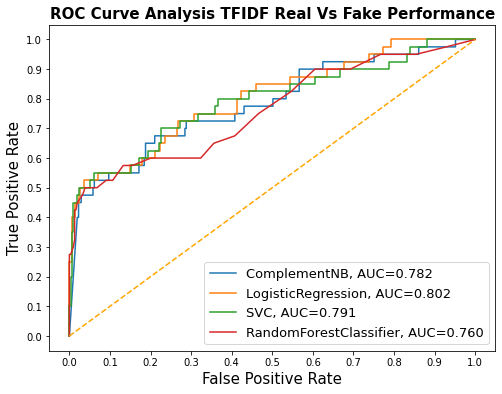

<Figure size 432x288 with 0 Axes>

In [ ]:
makeROC([TopicNB, TopicLR, TopicSVM, TopicRF], "TFIDF Real Vs Fake Performance", Test_X, Test_Y) 
plt.savefig('/content/drive/MyDrive/Master_Thesis_D_Amico/images/ROC_topic_over.png')